In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# use ggplot style
plt.style.use('ggplot')


def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")

In [2]:
#### Create adjacency matrix

# Define distance metrics
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y)**2))

def inverse_distance(x, y):
    return 1 / euclidean_distance(x, y)

# Create adjacency matrix function
def create_adjacency_matrix(data, distance_metric):
    n = data.shape[0]
    adjacency_matrix = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:  # we don't calculate the distance of the object to itself
                # we extract the position [x, y] for both objects i and j
                position_i = data[i, 1:3]
                position_j = data[j, 1:3]
                adjacency_matrix[i, j] = distance_metric(position_i, position_j)
    return adjacency_matrix

# Validate input
def validate_input(X, adjacency_matrix):
    # X should be a 2D tensor
    assert X.dim() == 2, f"X must be 2D, but got shape {X.shape}"

    # The number of nodes should be the same in X and the adjacency matrix
    assert X.shape[0] == adjacency_matrix.shape[0] == adjacency_matrix.shape[1], \
        f"Mismatch in number of nodes: got {X.shape[0]} nodes in X, but {adjacency_matrix.shape[0]} nodes in adjacency matrix"

    # The adjacency matrix should be square
    assert adjacency_matrix.shape[0] == adjacency_matrix.shape[1], \
        f"Adjacency matrix must be square, but got shape {adjacency_matrix.shape}"

    print("All checks passed.")


In [3]:
# Load and examine sample data
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state(X): shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state(y): shape (n_bodies, [x, y])

"""


X, y= load_array('data/task 1/train/trajectory_0.npz', task='task 1')
X = torch.tensor(X, dtype=torch.float32)


In [4]:
# Testing adjacency matrix
adjacency_matrix = create_adjacency_matrix(X, inverse_distance)

In [5]:
# Test network
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data

class SimpleGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(SimpleGNN, self).__init__()
        self.conv1 = GraphConv(num_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st Graph Convolution layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # 2nd Graph Convolution layer
        x = self.conv2(x, edge_index)

        return x


# Convert adjacency matrix to edge_index
# WARNING! This will 'Delete' the distances between the nodes
edge_index = adjacency_matrix.nonzero().t()

# Create a Data object
data = Data(x=X, edge_index=edge_index)

# Create an instance of our GNN
model = SimpleGNN(num_features=5, hidden_channels=32, num_classes=2)

# Pass the graph through the model
out = model(data)

print(out.shape)
edge_index[:, 4]

torch.Size([8, 2])


tensor([0, 5])

In [6]:
# Model Zoo
from torch_geometric.nn import SAGEConv

class MinGraphSAGE(torch.nn.Module):
    # FINAL MODEL!
    def __init__(self, num_features, hidden_channels, num_classes):
        super(MinGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, num_classes)

        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # Droput
        x = self.dropout(x)

        # 2nd GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # 3rd GraphSAGE layer
        x = self.conv3(x, edge_index)

        return x

from torch_geometric.nn import BatchNorm



In [7]:
# DataLoader

from torch_geometric.data import Dataset, Data, DataLoader

class MyDataset(Dataset):
    def __init__(self, root, filenames, transform=None, pre_transform=None):
        self.filenames = filenames
        super(MyDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return self.filenames

    def len(self):
        return len(self.filenames)

    def get(self, idx):
        X, y = load_array(self.filenames[idx], task='task 1')
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        adjacency_matrix = create_adjacency_matrix(X, inverse_distance)
        edge_index = adjacency_matrix.nonzero().t()

        data = Data(x=X, y=y, edge_index=edge_index)

        return data

filenames = [f'data/task 1/train/trajectory_{i}.npz' for i in range(900)]

split_point = 720 # take 20% of the data for validation

# Create two subsets for train/validation split from the filenames list
train_filenames = filenames[:split_point]
val_filenames = filenames[split_point:]

train_dataset = MyDataset(root='data/task 1/train', filenames=train_filenames)
train_dataloader = DataLoader(train_dataset, batch_size=32)

# Create validation dataset from val_filenames
val_dataset = MyDataset(root='data/task 1/train', filenames=val_filenames)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Prepare for validation data set

test_filenames = [f'data/task 1/test/trajectory_{i}.npz' for i in range(901, 1000)]
test_dataset = MyDataset(root='data/task 1/test', filenames=test_filenames)
test_dataloader = DataLoader(test_dataset, batch_size=32)

c:\Users\dagos\miniconda3\envs\mlcourse\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 1, Training Loss: 7.204667568206787, Val Loss: 6.859067461225721
Epoch: 2, Training Loss: 7.046130180358887, Val Loss: 6.117663584815132
Epoch: 3, Training Loss: 6.68977165222168, Val Loss: 5.885118442111545
Epoch: 4, Training Loss: 6.518742084503174, Val Loss: 5.84132523006863
Epoch: 5, Training Loss: 6.570226192474365, Val Loss: 5.746532440185547
Epoch: 6, Training Loss: 6.579742431640625, Val Loss: 5.602551587422689
Epoch: 7, Training Loss: 6.244710922241211, Val Loss: 5.449241489834256
Epoch: 8, Training Loss: 6.130970478057861, Val Loss: 5.374829546610514
Epoch: 9, Training Loss: 5.632474422454834, Val Loss: 5.338715797000461
Epoch: 10, Training Loss: 5.630383491516113, Val Loss: 5.276981925964355
Epoch: 11, Training Loss: 5.719899654388428, Val Loss: 5.240969901614719
Epoch: 12, Training Loss: 5.241686820983887, Val Loss: 5.226670085059272
Epoch: 13, Training Loss: 5.229151725769043, Val Loss: 5.1986084090338815
Epoch: 14, Training Loss: 5.457417011260986, Val Loss: 5.1707

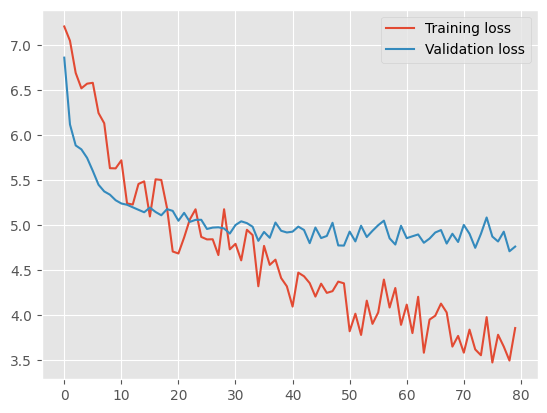

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MinGraphSAGE(num_features=5, hidden_channels=64, num_classes=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

# Store losses
train_losses = []
val_losses = []

epochs = 80

for epoch in range(epochs):  
    # Training
    model.train()
    for batch in train_dataloader:
        batch = batch.to(device)  # move batch to the device
        optimizer.zero_grad()  # set gradients to zero
        out = model(batch)  # forward pass
        loss = criterion(out, batch.y)  # compute loss
        loss.backward()  # backward pass (compute gradients)
        optimizer.step()  # update model parameters
    train_losses.append(loss.item())

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            out = model(batch)
            val_loss += criterion(out, batch.y).item() * batch.num_graphs
        
    val_loss /= len(val_dataset)  # compute average validation loss
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}, Training Loss: {loss.item()}, Val Loss: {val_loss}')


# Plot losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [10]:
# Calculate MSE loss on test set
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.to(device)
        out = model(batch)
        test_loss += criterion(out, batch.y).item() * batch.num_graphs
    
test_loss /= len(test_dataset)  # compute average validation loss
print(f'Test Loss for task 1: {test_loss}')

Test Loss for task 1: 3.5467068041213836


In [11]:
# Calculate static and linear baselines (formula on ANS)
def static_baseline(X):
    return X[:, 1:3]  # initial x,y coordinates

def linear_baseline(X):
    return X[:, 1:3] + X[:, 3:5] * 5  # initial x,y coordinates plus velocity times time

def compute_baseline_loss(baseline_fn, dataloader):
    total_loss = 0
    criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

    for batch in dataloader:
        batch = batch.to(device)
        predictions = baseline_fn(batch.x).to(device)
        total_loss += criterion(predictions, batch.y).item() * batch.num_graphs

    return total_loss / len(dataloader.dataset)

train_loss_static = compute_baseline_loss(static_baseline, train_dataloader)
train_loss_linear = compute_baseline_loss(linear_baseline, train_dataloader)

val_loss_static = compute_baseline_loss(static_baseline, val_dataloader)
val_loss_linear = compute_baseline_loss(linear_baseline, val_dataloader)

test_loss_static = compute_baseline_loss(static_baseline, test_dataloader)
test_loss_linear = compute_baseline_loss(linear_baseline, test_dataloader)

 # now print out with filler spaces to make it easier to read
print(f'Training Loss   - Static Baseline: {train_loss_static:0.4f}, Linear Baseline: {train_loss_linear:0.4f}')
print(f'Validation Loss - Static Baseline: {val_loss_static:0.4f}, Linear Baseline: {val_loss_linear:0.4f}')
print(f'Test Loss - Static Baseline: {test_loss_static:0.4f}, Linear Baseline: {test_loss_linear:0.4f}')


Training Loss   - Static Baseline: 14.0342, Linear Baseline: 21.9515
Validation Loss - Static Baseline: 13.5344, Linear Baseline: 23.0688
Test Loss - Static Baseline: 11.4824, Linear Baseline: 20.2710


# Experiments

Take the 10 trajectories with highest and lowest loss to analyse.

c:\Users\dagos\miniconda3\envs\mlcourse\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


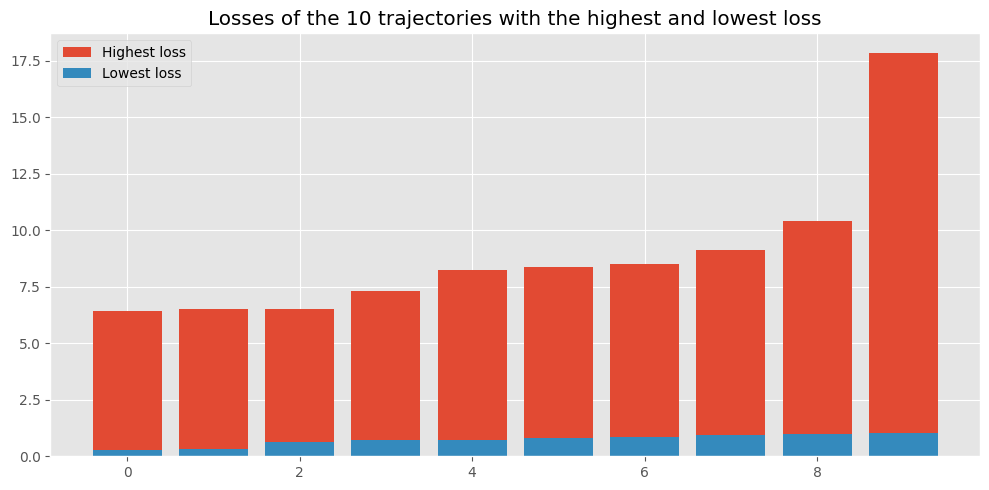

In [12]:
# 6a experiment: grab 10 trajectories from the experiment set that were correctly predicted and 10 that were incorrectly predicted to analyse them

experiment_dataloader = DataLoader(test_dataset, batch_size=1)

experiment_losses = []
experiment_predictions = []
experiment_labels = []

model.eval()
with torch.no_grad():
    for batch in experiment_dataloader:
        batch = batch.cpu()
        out = model.cpu()(batch)
        loss = criterion(out, batch.y)
        experiment_losses.append(loss.item())
        experiment_predictions.append(out)
        experiment_labels.append(batch.y)

# Get the indices of the 10 trajectories with the highest loss
highest_loss_indices = np.argsort(experiment_losses)[-10:]

# Get the indices of the 10 trajectories with the lowest loss
lowest_loss_indices = np.argsort(experiment_losses)[:10]

# np.array(experiment_losses)[highest_loss_indices]
# plot 10 bars with the losses of the 10 trajectories with the highest loss and the 10 trajectories with the lowest loss with the same y-axis
plt.figure(figsize=(10, 5))
plt.bar(np.arange(10), np.array(experiment_losses)[highest_loss_indices], label='Highest loss')
plt.bar(np.arange(10), np.array(experiment_losses)[lowest_loss_indices], label='Lowest loss')
plt.title('Losses of the 10 trajectories with the highest and lowest loss')
plt.tight_layout()
plt.legend()
plt.show()


In [13]:
def plot_trajectories(indices, title=""):
    trajectories = test_dataset[indices]

    # fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True)
    fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True, figsize=(20, 5))

    # set axes limits
    axes[0].set_xlim(-10, 10)
    axes[0].set_ylim(-10, 10)

    # iterate over projections
    for i in range(len(trajectories)):
        # Get the initial position
        initial_position_x = trajectories.x[i][1]
        initial_position_y = trajectories.x[i][2]

        # Get the final position
        final_position_x = trajectories.y[i][0]
        final_position_y = trajectories.y[i][1]

        axes[i].scatter(initial_position_x, initial_position_y, label='Initial position', marker='o', s=100)
        axes[i].scatter(final_position_x, final_position_y, label='Final position', marker='x', s=100)

        # Get the predicted position
        predicted_position_x = experiment_predictions[indices][i][0]
        predicted_position_y = experiment_predictions[indices][i][1]

        axes[i].scatter(predicted_position_x, predicted_position_y, label='Predicted position', marker='p', s=100)

        # Draw dashed line from initial position to predicted position
        axes[i].plot([initial_position_x, predicted_position_x], [initial_position_y, predicted_position_y], 'r--')

        # Get the label
        label = experiment_labels[indices]

        # Draw dashed line from initial position to label
        axes[i].plot([initial_position_x, label[i][0]], [initial_position_y, label[i][1]], 'b--')

        axes[i].legend()
    
    # set title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


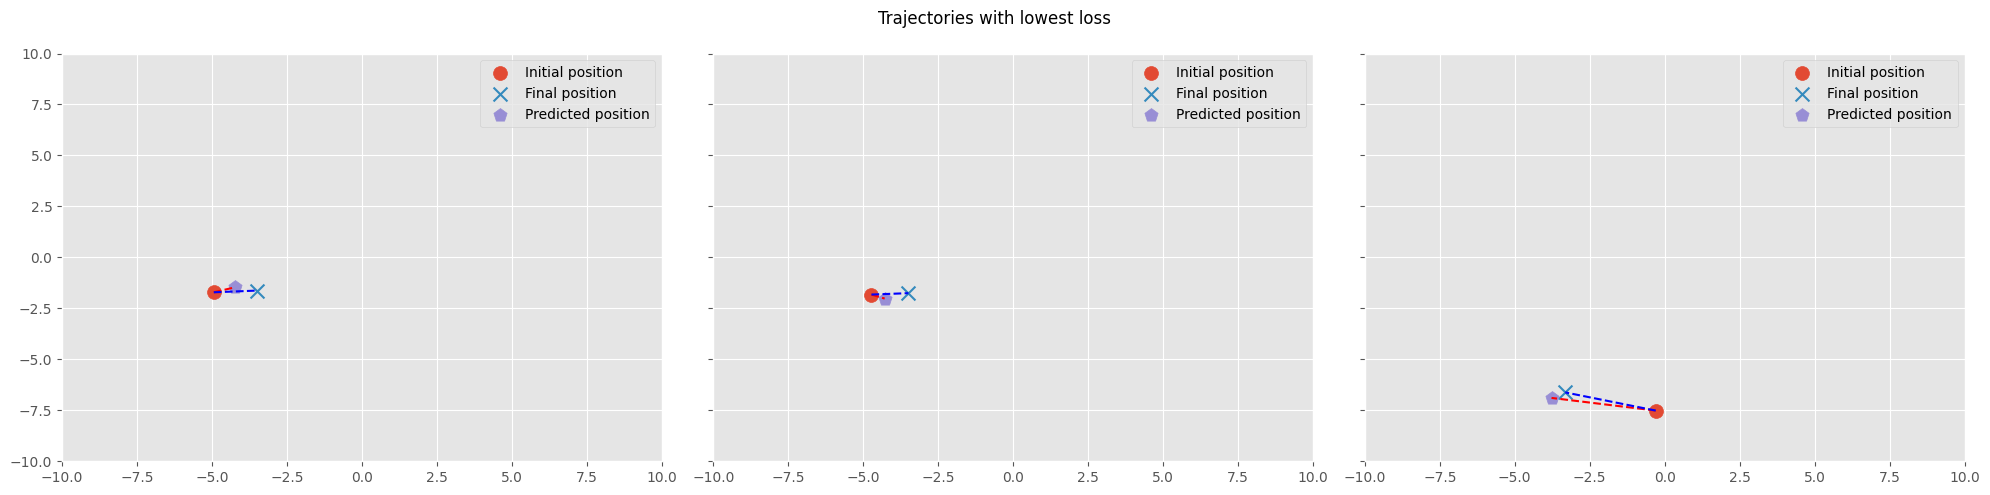

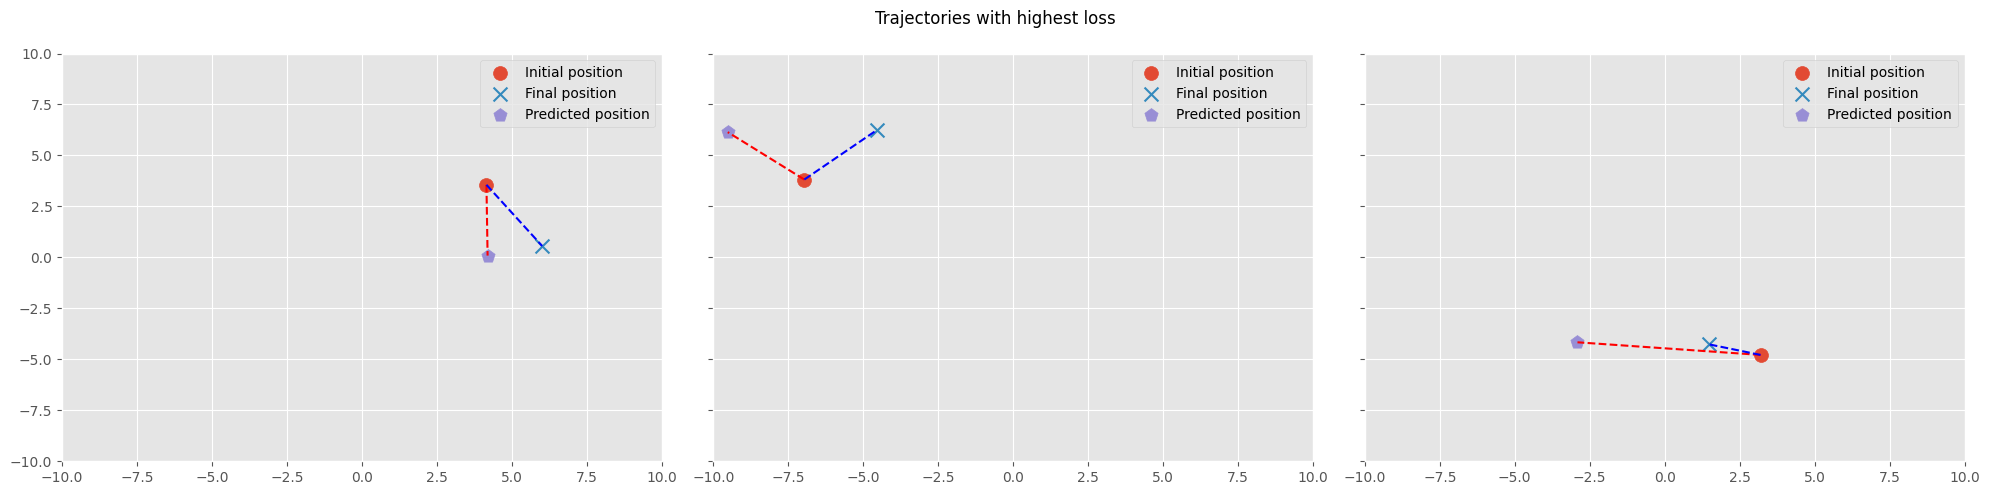

In [14]:
plot_trajectories(lowest_loss_indices[0], title="Trajectories with lowest loss")
plot_trajectories(highest_loss_indices[-1], title="Trajectories with highest loss")

In [ ]:
#Printing some values of the initial configuration to see if there are any differences between the trajectories with the highest and lowest loss

In [16]:
test_dataset[lowest_loss_indices[0]].x

tensor([[ 4.1742, -4.9411, -1.7119,  2.6389, -0.8456],
        [ 2.7585, -4.7310, -1.8229, -3.6578,  1.8357],
        [ 4.6407, -0.3010, -7.5130, -0.4440, -0.1771],
        [ 1.5716,  3.1846,  5.7561,  0.7224, -0.4534]])

In [18]:
test_dataset[lowest_loss_indices[1]].x

tensor([[ 2.7354,  2.5184,  2.5226,  0.8648, -0.3181],
        [ 3.1135,  3.6977, -4.6671, -0.2411, -0.5863],
        [ 3.4997, -5.7666, -5.7946, -0.1564,  0.5217],
        [ 1.7253,  3.3607, -3.7166, -0.6188,  0.5039]])

In [79]:
test_dataset[lowest_loss_indices[2]].x

tensor([[ 1.0472,  3.3477, -5.6210,  0.2406,  0.6256],
        [ 1.2819, -6.0629,  5.9189,  0.5662,  0.2915],
        [ 1.3394,  5.1078,  3.9074,  0.6101, -0.5960],
        [ 2.8267, -4.4778, -4.9823, -0.9333,  0.5315],
        [ 3.0395, -5.9326, -4.2534,  0.5526,  0.2918],
        [ 1.2931, -3.7802,  2.0485,  0.5656,  0.5708],
        [ 2.4250,  4.6180, -5.0047, -1.0050, -0.4335],
        [ 1.5942,  3.5520, -4.6977,  0.5454, -1.4470]])

In [105]:
test_dataset[highest_loss_indices[7]].x

tensor([[ 1.0546,  0.3647,  2.3750,  0.8822,  2.3617],
        [ 1.9398,  4.3665,  0.1935, -0.3719, -0.7032],
        [ 2.4461,  2.4027,  6.0252,  0.4064, -1.0583],
        [ 1.5718, -2.5888,  6.2677,  0.0829, -0.0945],
        [ 3.0935, -6.2327,  3.7446, -0.6308,  1.1256],
        [ 3.4327, -7.1855,  4.9012,  0.4967, -0.2926],
        [ 3.3264,  3.3379,  4.4637, -0.3268, -0.2605]])

In [106]:
test_dataset[highest_loss_indices[8]].x

tensor([[ 1.1036,  4.8714, -1.7370, -1.8168, -0.5997],
        [ 1.2827, -4.4145,  3.5589, -0.8841,  1.3358],
        [ 2.5679, -5.3894,  4.0729,  1.9687, -0.6166],
        [ 4.9725,  5.8418, -1.9034,  0.2416, -0.6608],
        [ 4.5179, -5.8250,  4.4613,  0.3198,  1.0695],
        [ 4.3107,  7.4128,  0.3326, -0.1878, -1.4517],
        [ 4.9320, -3.9639, -1.3465, -0.7610,  1.0632]])

In [108]:
test_dataset[highest_loss_indices[9]].x

tensor([[ 2.0852,  4.1499,  3.5594,  0.5230, -0.3615],
        [ 3.8131, -6.9704,  3.8182,  0.3784,  0.5707],
        [ 3.0442,  3.1951, -4.7837, -6.8446,  0.4198],
        [ 4.0704,  3.1956, -4.7588,  4.4965, -0.6634]])

In [60]:
type("%.3f"%float(test_dataset[highest_loss_indices[2]].x[0][0]))

str

In [97]:
def plot_singular_initial_configuration(indices, title=""):
    trajectories = test_dataset[indices]
    

    # fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True)
    fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20, 5))

    # set axes limits
    axes.set_xlim(-10,10)
    axes.set_ylim(-10,10)
    # iterate over projections
    for i in range(len(trajectories.x)):
        #Get the initial position of all the object in the scene
        
        # Get the initial position
        initial_position_x = trajectories.x[i][1]
        initial_position_y = trajectories.x[i][2]
        mass = "%.3f"%float(trajectories.x[i][0])
        axes.scatter(initial_position_x, initial_position_y, label='Initial position object '+str(i), marker='o', s=50)
        #axes[i].scatter(final_position_x, final_position_y, label='Final position', marker='x', s=100)
        axes.annotate(mass, (initial_position_x, initial_position_y), fontsize=10)
        # Get the predicted position
        #predicted_position_x = experiment_predictions[indices][i][0]
        #predicted_position_y = experiment_predictions[indices][i][1]

        #axes[i].scatter(predicted_position_x, predicted_position_y, label='Predicted position', marker='p', s=100)

        # Draw dashed line from initial position to predicted position
        #axes[i].plot([initial_position_x, predicted_position_x], [initial_position_y, predicted_position_y], 'r--')

        # Get the label
        #label = experiment_labels[indices]

        # Draw dashed line from initial position to label
        #axes[i].plot([initial_position_x, label[i][0]], [initial_position_y, label[i][1]], 'b--')

        #axes.legend()
    
    # set title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [98]:
def plot_singular_final_configuration(indices, title=""):
    trajectories = test_dataset[indices]
    

    # fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True)
    fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20, 5))

    # set axes limits
    axes.set_xlim(-10, 10)
    axes.set_ylim(-10, 10)
    # iterate over projections
    for i in range(len(trajectories.y)):
        #Get the initial position of all the object in the scene
        
        # Get the initial position
        initial_position_x = trajectories.y[i][0]
        initial_position_y = trajectories.y[i][0]
        mass = "%.3f"%float(trajectories.x[i][0])
        axes.scatter(initial_position_x, initial_position_y, label='Final position object '+str(i), marker='o', s=50)
        #axes[i].scatter(final_position_x, final_position_y, label='Final position', marker='x', s=100)
        axes.annotate(mass, (initial_position_x, initial_position_y), fontsize=10)
        # Get the predicted position
        #predicted_position_x = experiment_predictions[indices][i][0]
        #predicted_position_y = experiment_predictions[indices][i][1]

        #axes[i].scatter(predicted_position_x, predicted_position_y, label='Predicted position', marker='p', s=100)

        # Draw dashed line from initial position to predicted position
        #axes[i].plot([initial_position_x, predicted_position_x], [initial_position_y, predicted_position_y], 'r--')

        # Get the label
        #label = experiment_labels[indices]

        # Draw dashed line from initial position to label
        #axes[i].plot([initial_position_x, label[i][0]], [initial_position_y, label[i][1]], 'b--')

        #axes.legend()
    
    # set title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


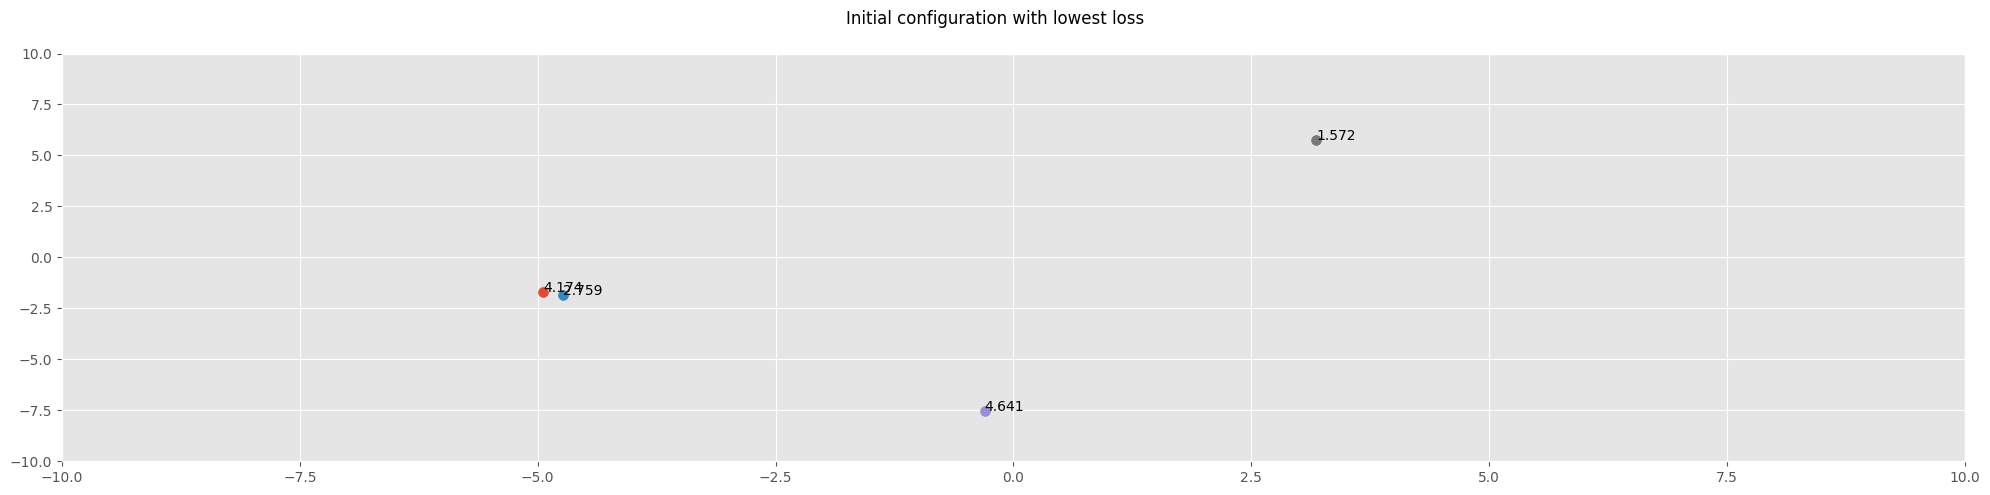

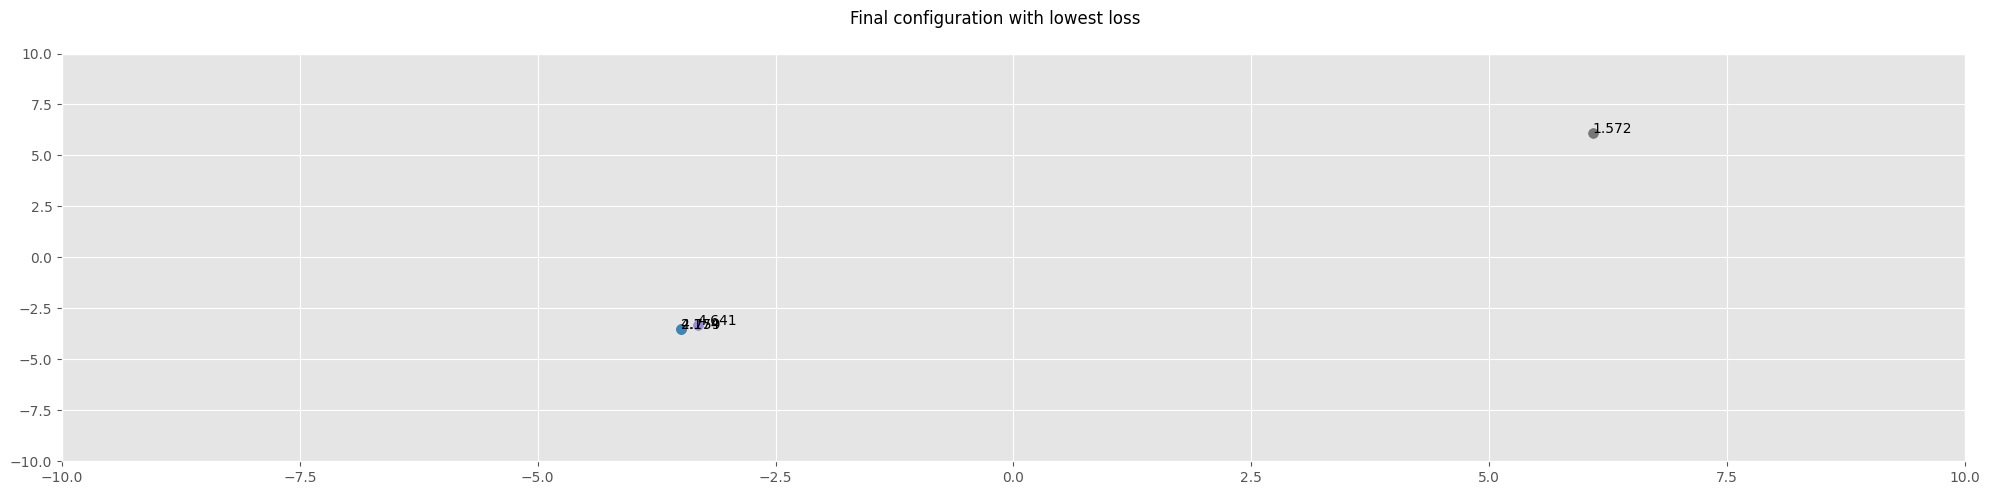

In [99]:
plot_singular_initial_configuration(lowest_loss_indices[0], title="Initial configuration with lowest loss")
plot_singular_final_configuration(lowest_loss_indices[0], title="Final configuration with lowest loss")

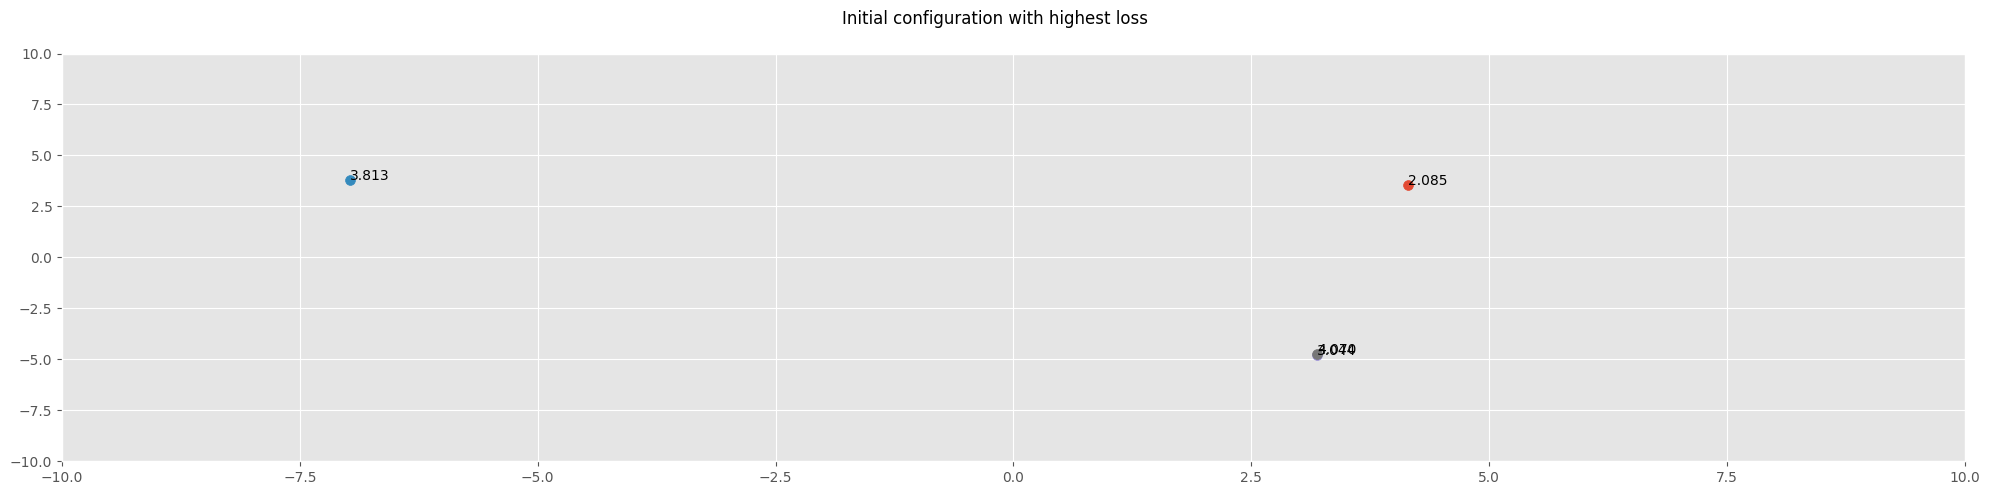

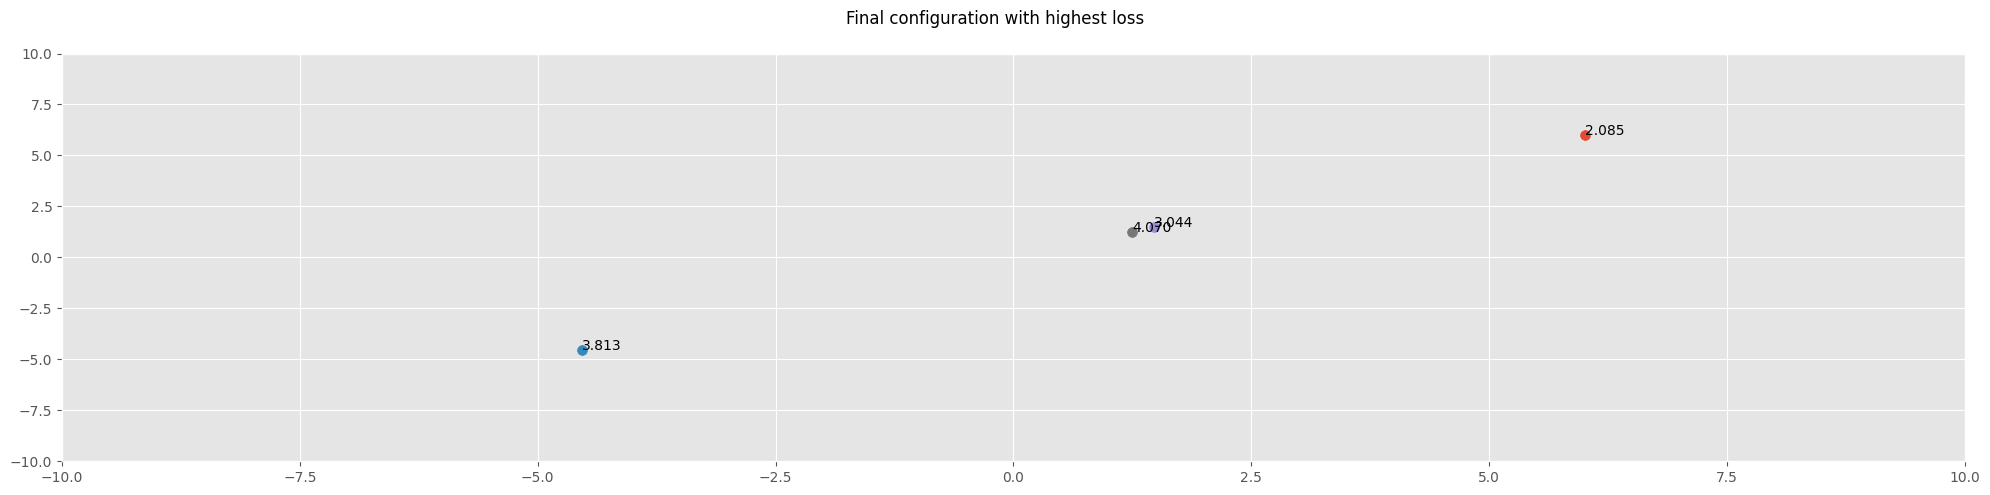

In [100]:
plot_singular_initial_configuration(highest_loss_indices[-1], title="Initial configuration with highest loss")
plot_singular_final_configuration(highest_loss_indices[-1], title="Final configuration with highest loss")

In [102]:
def plot_multiple_initial_configuration(indices, title=""):
    trajectories = []
    for j in range(len(indices)):
        trajectories.append(test_dataset[indices[j]])
    

    # fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True)
    fig, axes = plt.subplots(1, len(indices), sharex=True, sharey=True, figsize=(20, 5))

    # set axes limits
    #axes[0].set_xlim(-10, 10)
    #axes[0].set_ylim(-10, 10)
    for j in range(len(indices)):
        index = indices[j]
        # iterate over projections
        for i in range(len(trajectories[j].x)):
            #Get the initial position of all the object in the scene
            
            # Get the initial position
            initial_position_x = trajectories[j].x[i][1]
            initial_position_y = trajectories[j].x[i][2]
            mass = "%.3f"%float(trajectories[j].x[i][0])
            axes[j].scatter(initial_position_x, initial_position_y, label='Initial position object '+str(i), marker='o', s=50)
            #axes[i].scatter(final_position_x, final_position_y, label='Final position', marker='x', s=100)
            axes[j].annotate(mass, (initial_position_x, initial_position_y), fontsize=10)
            # Get the predicted position
            #predicted_position_x = experiment_predictions[indices][i][0]
            #predicted_position_y = experiment_predictions[indices][i][1]

            #axes[i].scatter(predicted_position_x, predicted_position_y, label='Predicted position', marker='p', s=100)

            # Draw dashed line from initial position to predicted position
            #axes[i].plot([initial_position_x, predicted_position_x], [initial_position_y, predicted_position_y], 'r--')

            # Get the label
            #label = experiment_labels[indices]

            # Draw dashed line from initial position to label
            #axes[i].plot([initial_position_x, label[i][0]], [initial_position_y, label[i][1]], 'b--')

            #axes[j].legend()
    
    # set title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [101]:
def plot_multiple_final_configuration(indices, title=""):
    trajectories = []
    for j in range(len(indices)):
        trajectories.append(test_dataset[indices[j]])
    

    # fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True)
    fig, axes = plt.subplots(1, len(indices), sharex=True, sharey=True, figsize=(20, 5))

    # set axes limits
    #axes[0].set_xlim(-10, 10)
    #axes[0].set_ylim(-10, 10)
    for j in range(len(indices)):
        index = indices[j]
        # iterate over projections
        for i in range(len(trajectories[j].x)):
            #Get the initial position of all the object in the scene
            
            # Get the initial position
            initial_position_x = trajectories[j].y[i][0]
            initial_position_y = trajectories[j].y[i][1]
            mass = "%.3f"%float(trajectories[j].x[i][0])
            axes[j].scatter(initial_position_x, initial_position_y, label='Initial position object '+str(i), marker='o', s=50)
            #axes[i].scatter(final_position_x, final_position_y, label='Final position', marker='x', s=100)
            axes[j].annotate(mass, (initial_position_x, initial_position_y), fontsize=10)
            # Get the predicted position
            #predicted_position_x = experiment_predictions[indices][i][0]
            #predicted_position_y = experiment_predictions[indices][i][1]

            #axes[i].scatter(predicted_position_x, predicted_position_y, label='Predicted position', marker='p', s=100)

            # Draw dashed line from initial position to predicted position
            #axes[i].plot([initial_position_x, predicted_position_x], [initial_position_y, predicted_position_y], 'r--')

            # Get the label
            #label = experiment_labels[indices]

            # Draw dashed line from initial position to label
            #axes[i].plot([initial_position_x, label[i][0]], [initial_position_y, label[i][1]], 'b--')

            #axes[j].legend()
    
    # set title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [ ]:
#PLOTTING INITIAL CONFIGURATION OF SYSTEMS WHERE THE PREDICTIONS ARE GOOD AND SYSTEMS WHERE THE PREDICTIONS ARE BAD

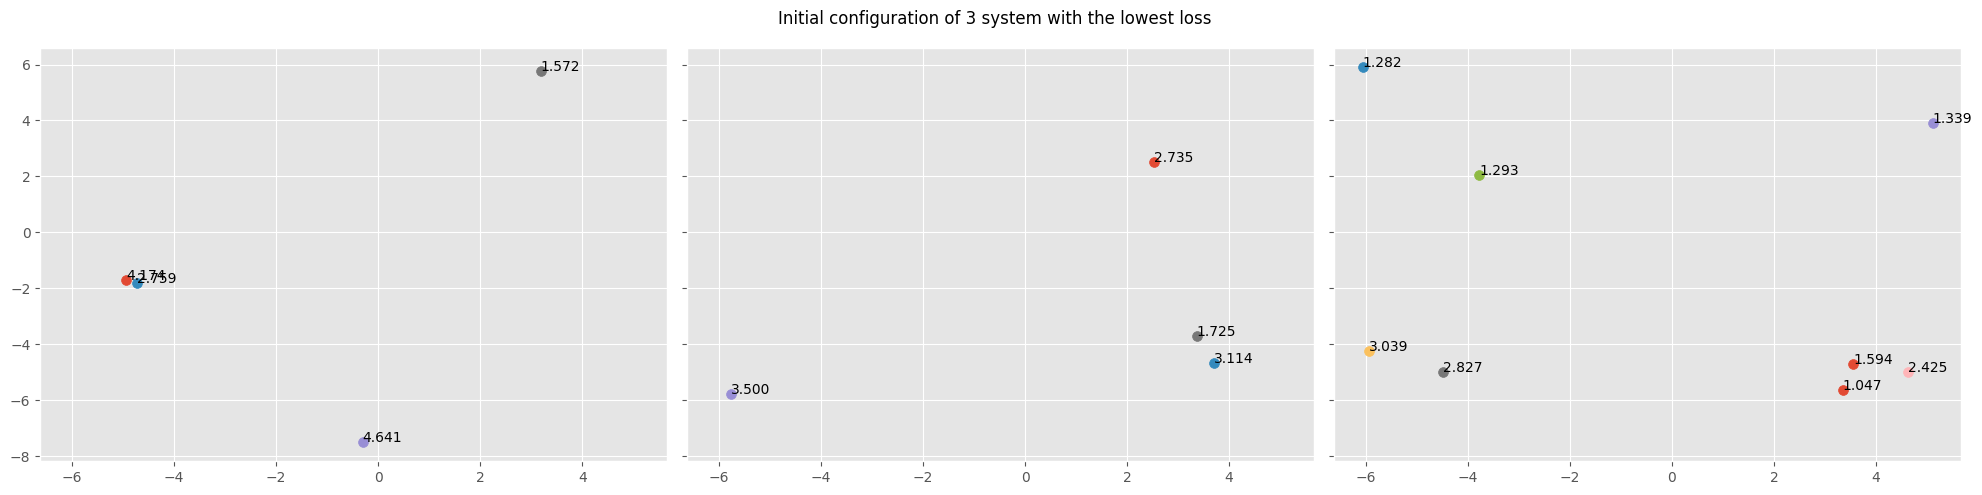

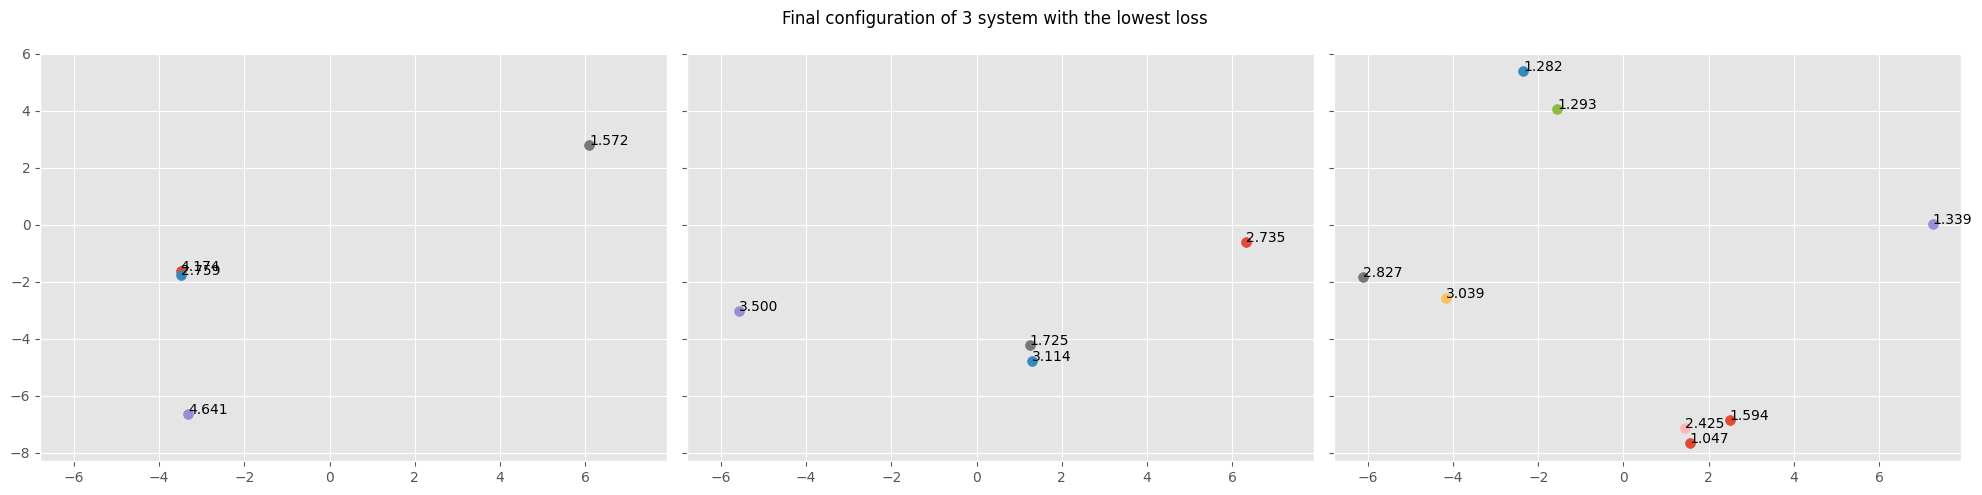

In [103]:
plot_multiple_initial_configuration(lowest_loss_indices[:3], title="Initial configuration of 3 system with the lowest loss")
plot_multiple_final_configuration(lowest_loss_indices[:3], title="Final configuration of 3 system with the lowest loss")

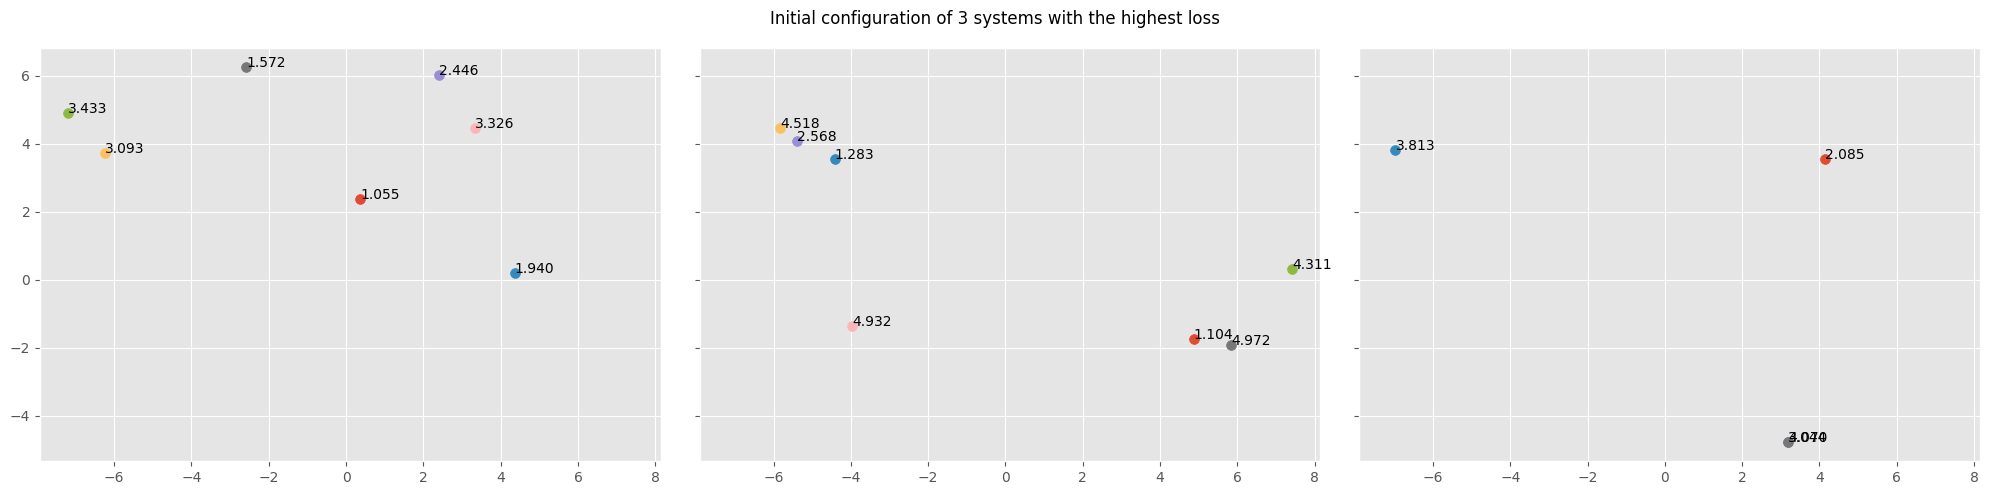

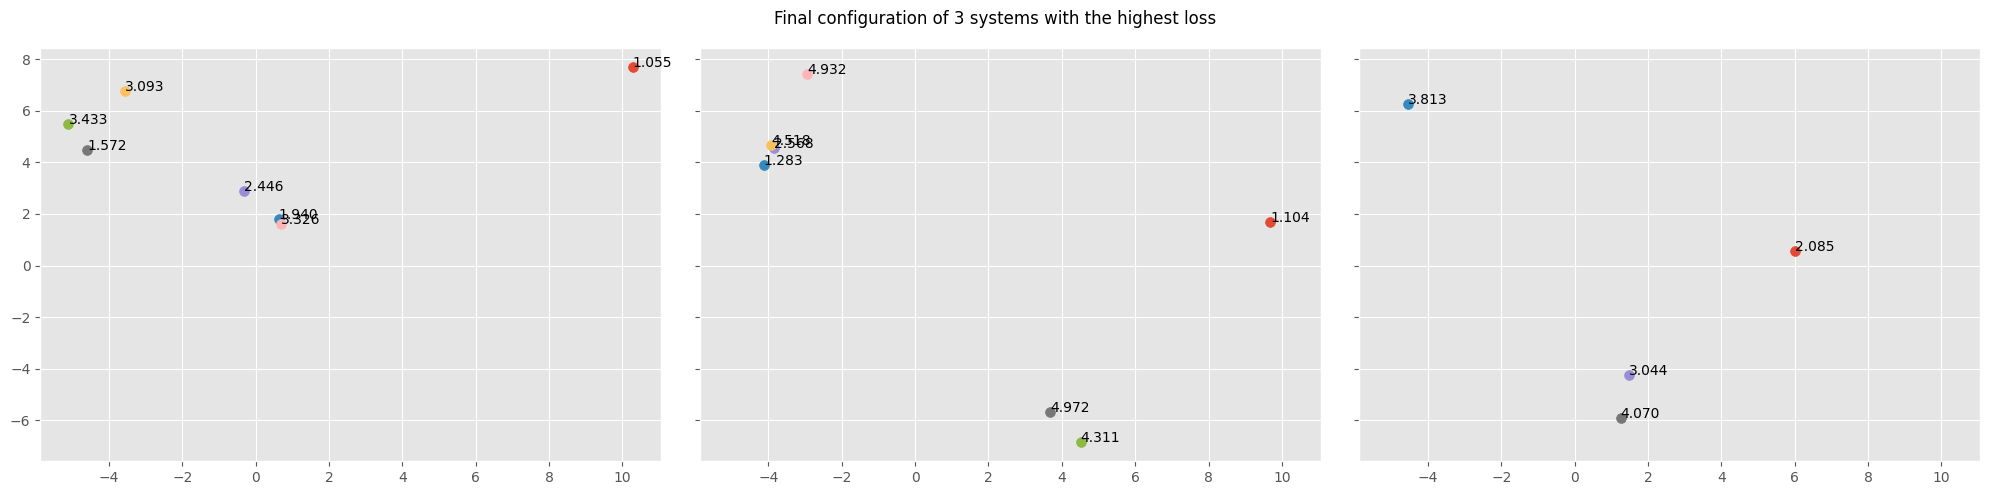

In [104]:
plot_multiple_initial_configuration(highest_loss_indices[7:], title="Initial configuration of 3 systems with the highest loss")
plot_multiple_final_configuration(highest_loss_indices[7:], title="Final configuration of 3 systems with the highest loss")

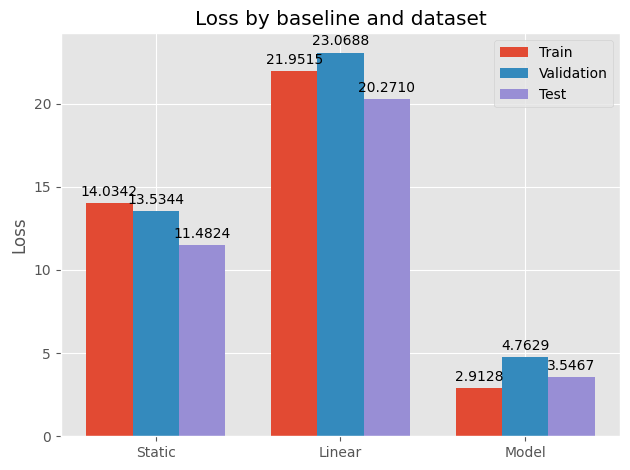

In [15]:
# Create barplot with static and linear baseline losses for train-test-val 3 separate bars

import matplotlib.pyplot as plt
import numpy as np

train_losses = [train_loss_static, train_loss_linear, loss.item()]
val_losses = [val_loss_static, val_loss_linear, val_loss]
test_losses = [test_loss_static, test_loss_linear, test_loss]

x = np.arange(len(train_losses))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_losses, width, label='Train')
rects2 = ax.bar(x, val_losses, width, label='Validation')
rects3 = ax.bar(x + width, test_losses, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss')
ax.set_title('Loss by baseline and dataset')
ax.set_xticks(x)
ax.set_xticklabels(['Static', 'Linear', "Model"])
ax.legend()

# Add numbers on top of bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:  # for each bar
        height = rect.get_height()  # get height of bar
        ax.annotate(f'{height:0.4f}',  # annotate with height
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # put label in the middle of the bar
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Do the autolabel
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()